In [1]:
import pandas as pd
import numpy as np
from unidecode import unidecode
import matplotlib.pyplot as plt

# This seems to just make all plots wider, which is nice and makes visualizing easier
plt.rcParams['figure.figsize'] = [20,10]

# Cleaning up the data

The first step will be to clean up (more) the two datasets. The code is given, but the general idea of the cleaning is just to make the data easier to parse.

## Cleaning wrestler info

We'll start with cleaning up the wrestling info that's contained. The first two methods are just helper methods used later, the core of the cleaning is in the clean_wrestler _info method.



In [2]:
def country_simplifier(row):
    """Due to the countries where pro wrestling is more popular, we will simplify the countries. This is mainly using only the 'main' wrestling countries, and leaving the others as 'other'.

    The decision on keeping these 4 countries (USA, Japan, Mexico, and UK) as the 'main' wrestling countries was done due to knowledge of the field, as well as information obtained from the 5 star match dataframe.

    This is also to deal with issues of the names being mispelled for whatever reason"""
    if (row['Birth Country'] == 'United States of America') or (row['Birth Country'] == 'United States of Americ'):
        return 'USA'
    elif (row['Birth Country'] == 'Canada') or (row['Birth Country'] == 'Canad'):
        # Because of how canada and US are linked in wrestling world, I'll mark the two together
        return 'USA'
    elif (row['Birth Country'] == 'Japa') or (row['Birth Country'] == 'Japan'):
        return 'Japan'
    elif (row['Birth Country'] == 'Mexico') or (row['Birth Country'] == 'Mexic'):
        return 'Mexico'
    elif (row['Birth Country'] == 'United Kingdom') or (row['Birth Country'] == 'United Kingdo'):
        return 'UK'
    else:
        return 'Other'

In [3]:
def extract_country(str_to_eval):
    """Birthplace has the country hidden inside, so this method exists to extract whatever the country might be.

    This method was done because sometimes the place has extra location info (IE the city, or state), sometimes it's just a country. So an extra method is needed to distinguish between these two cases"""
    #print(str_to_eval)
    # should check if the string is empty?

    start_index = str_to_eval.find('(')

    # Start index being -1 means there's no (, so I'll assume that if there's no (, then the birthplace is already a country
    if start_index == -1:
        return str_to_eval
    else:
        # Have to increase it by one, I don't care about the (, but what's inside them
        start_index += 1
        end_index = str_to_eval.find(")")
        return str_to_eval[start_index: end_index]


In [4]:
def clean_wrestler_info(wrestler_info: pd.DataFrame):
    """Method to make the general wreslter info easier to parse

    Modifies it in place, so it does not return anything"""
    # This adds the country of birth as a column to the dataframe
    # Done because country is usually easier to work with
    birth_countries = wrestler_info[~wrestler_info['Birthplace'].isnull()]['Birthplace'].apply(extract_country)
    wrestler_info['Birth Country'] = birth_countries

    # Obtains the height and weight, and allows them to be input into the system
    height_and_weight = wrestler_info[~wrestler_info['Weight and Height'].isnull()]['Weight and Height'].str.split('at', expand=True)

    # Processing the weight
    weight = height_and_weight[~height_and_weight[0].isnull()][0].apply(lambda st: st[st.find("(")+1:st.find(")")])
    weight = pd.to_numeric(weight.str[:-3], errors='coerce')
    weight = weight[~weight.isnull()]
    wrestler_info['Weight'] = weight

    # Processing the height
    height = height_and_weight[~height_and_weight[1].isnull()][1].apply(lambda st: st[st.find("(")+1:st.find(")")])
    height = pd.to_numeric(height.str[:-2], errors='coerce')
    height = height[~height.isnull()]
    wrestler_info['Height'] = height

    wrestler_info.drop(['Weight and Height'], axis=1, inplace=True)

    # Date of birth, debut, and death are contained in a weird string format. These lines take care of
    # cleaning stuff up and transforming the inputs into datetime values. Which makes later operations easier
    dob = wrestler_info['Date of Birth'].str.replace(r"\(.*\)","", regex=True)
    dob = pd.to_datetime(dob, errors='coerce')

    debut = wrestler_info['Debut'].str.replace(r"\(.*\)","", regex=True)
    debut = pd.to_datetime(debut, errors='coerce')

    death = wrestler_info['Date of Death'].str.replace(r"\(.*\)","", regex=True)
    death = pd.to_datetime(death, errors='coerce')

    wrestler_info['Date of Birth'] = dob
    wrestler_info['Debut'] = debut
    wrestler_info['Date of Death'] = death

    # Region based on the 'main' wrestling countries that was explained earlier on
    wrestler_info['Region'] = wrestler_info.apply(lambda row: country_simplifier(row), axis=1)

    # New column on whether the real name is known or not
    wrestler_info['Name Known'] = np.where(wrestler_info['Real Name'] == 'unknown', False, True)

    # Age when they had their debut
    wrestler_info['Debut Age'] = ((wrestler_info['Debut'] - wrestler_info['Date of Birth']) / np.timedelta64(1, 'Y')).apply(np.floor)

    # These columns aren't useful with the way we parsed them, so I'm just getting rid of them.
    # Matches fought would've had the number of matches, but with the way we extracted it, it just told us if they had a match (which everyone did)
    # Typical errors was used mainly for typos related to the wrestler's name
    wrestler_info.drop(['Matches Fought', 'Typical Error(s)'], axis=1, inplace=True)

    # Hair and mask matches are both types of betting matches, so we'll merge their information
    wrestler_info['Betting Matches Won'] = (wrestler_info['Hair Matches Won'] + wrestler_info['Mask Wins'] + wrestler_info['Hair Match Won'] + wrestler_info['Mask Win']).fillna(0).astype(int)
    wrestler_info['Betting Matches Lost'] = (wrestler_info['Hair Matches Lost'] + wrestler_info['Mask Losses'] + wrestler_info['Hair Match Lost'] + wrestler_info['Mask Loss']).fillna(0).astype(int)
    wrestler_info['Participated in Betting Match'] = np.where((wrestler_info['Betting Matches Lost'] > 0) | (wrestler_info['Betting Matches Won']>0), True, False)

    # Then dropping the 8 columns related to these gimmick matches
    wrestler_info.drop(['Hair Matches Won', 'Mask Wins', 'Hair Match Won', 'Mask Win', 'Hair Matches Lost', 'Mask Losses', 'Hair Match Lost', 'Mask Loss'], axis=1, inplace=True)

    # Family ties just means they're related to another wrestler. The difference between plural and singular is just amount
    # We'll consider them to be equal
    wrestler_info['Family Ties'] = np.where(wrestler_info['Familiy Tie'] | wrestler_info['Familiy Ties'], True, False)
    wrestler_info.drop(['Familiy Tie', 'Familiy Ties'], axis=1, inplace=True)

    # This is just not helpful
    wrestler_info.drop(['Alias'], inplace=True, axis=1)



In [5]:
wrestler_df = pd.read_csv('all_info_wrestlers.csv')
wrestler_df.drop(['Unnamed: 0'], axis=1, inplace=True)

# Extra step for consistency at some other point
wrestler_df['wrestler_name'] = wrestler_df['wrestler_name'].apply(lambda x: unidecode(x))

clean_wrestler_info(wrestler_df)

match_wrestler_info = pd.read_csv('Data/5_star_matches_wrestler_list.csv')
match_wrestler_info.drop(['Unnamed: 0'], axis=1, inplace=True)

# WWF and WWE are pretty much the same company, we'll just merge them directly.
match_wrestler_info['Promotion'] = np.where(match_wrestler_info['Promotion'] == 'WWF', 'WWE', match_wrestler_info['Promotion'])

In [6]:
wrestler_df

,id,Real Name,Birthplace,Date of Birth,Debut,wrestler_name,Date of Death,Height,Weight,Finisher,...,Student,Booked Promotions,Birth Country,Region,Name Known,Debut Age,Betting Matches Won,Betting Matches Lost,Participated in Betting Match,Family Ties
0,6990,Kazuchika Okada,"Anjo, Aichi (Japan)",1987-11-08,2004-08-29,Kazuchika Okada,NaT,1.91,109.0,3,...,0,0.0,Japan,Japan,True,16.0,0,0,False,False
1,216,Curtis Michael Hennig,"Robbinsdale, Minnesota (United States of America)",1958-03-28,1981-01-30,Curt Hennig,2003-02-10,1.91,118.0,1,...,0,0.0,United States of America,USA,True,22.0,0,0,False,True
2,458,Keiichi Yamada,"Hiroshima, Hiroshima (Japan)",1964-11-30,1984-03-03,Jushin Thunder Liger,NaT,1.68,94.0,3,...,0,0.0,Japan,Japan,True,19.0,1,0,True,False
3,766,Satoru Sayama,"Shimonoseki, Yamaguchi (Japan)",1957-11-24,1976-05-28,First Tiger Mask,NaT,1.73,96.0,2,...,0,0.0,Japan,Japan,True,18.0,2,0,True,False
4,64,Eduardo Gori Guerrero Llanes,"El Paso, Texas (United States of America)",1967-10-09,1987-09-18,Eddie Guerrero,2005-11-13,1.73,100.0,4,...,0,0.0,United States of America,USA,True,19.0,1,1,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26260,30188,Catherine Costigan,Limerick (Ireland),NaT,2010-12-18,Catherine Costigan,NaT,1.63,48.0,0,...,0,NaN,Ireland,Other,True,NaN,0,0,False,False
26261,30189,Amber Leibrock,"Hayward, California (United States of America)",1988-02-08,2015-06-09,Amber Leibrock,NaT,1.80,66.0,0,...,0,NaN,United States of America,USA,True,27.0,0,0,False,False
26262,30190,Gonzalo Mendiola Ortega,"San Antonio, Texas (United States of America)",1933-04-09,NaT,Pancho Lomas,2011-10-22,NaN,NaN,0,...,0,NaN,United States of America,USA,True,NaN,0,0,False,False
26263,30191,Otto Frederick Roehm,NaN,1882-08-02,NaT,Otto Roehm,1958-05-29,1.65,70.0,0,...,0,NaN,NaN,Other,True,NaN,0,0,False,False


## Cleaning the 5 star matches

The cleaning is adding the country of the promotion for each match, adding the 'gender' of the promotion, and adding a unique ID for each match.

The country follows the same form as the region, it's done for analysis further on.

In [7]:
promotion_country = {'CWF': 'USA', 'NJPW': 'Japan', 'UWF': 'Japan', 'AJPW': 'Japan', 'AJW': 'Japan', 'JCP': 'USA', 'WCW': 'USA', 'JWP': 'Japan', 'WWF': 'USA', 'AAA': 'Mexico', 'ECW': 'USA', 'Michinoku Pro': 'Japan', 'RINGS': 'Japan', 'Noah': 'Japan', 'ROH': 'USA', 'TNA': 'USA', 'WWE': 'USA', 'PWG': 'USA', 'La Triple W': 'Other', 'AEW': 'USA', 'OTT': 'Other', 'RPW': 'UK', 'Stardom': 'Japan'}

In [8]:
match_wrestler_info['Promotion Country'] = match_wrestler_info['Promotion'].map(promotion_country)
match_wrestler_info['match_id'] = (match_wrestler_info.index + 1)

# This is an ugly way of rearranging the columns, but it helps so much with visualization
cols = match_wrestler_info.columns.tolist()
cols = cols[:8] + cols[-2:] + cols[8:-2]

match_wrestler_info = match_wrestler_info[cols]

In [9]:
match_wrestler_info

,Date,Match,Promotion,Event,Rating,# of teams,Team Size,PPV,Promotion Country,match_id,...,Wrestler 3,Wrestler 4,Wrestler 5,Wrestler 6,Wrestler 7,Wrestler 8,Wrestler 9,Wrestler 10,Wrestler 11,Wrestler 12
0,"April 7, 1982",Ric Flair vs. Butch Reed,CWF,Miami Beach show,5.00,2,1,False,USA,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"April 21, 1983",Dynamite Kid vs. Tiger Mask,NJPW,Big Fight Series IINight 19,5.00,2,1,True,Japan,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"December 5, 1984",Kazuo Yamazaki vs. Nobuhiko Takada,UWF,Year-End SpecialDay 10,5.00,2,1,True,Japan,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"December 8, 1984",Bruiser Brody and Stan Hansen vs. Dory Funk Jr...,AJPW,Real World Tag LeagueNight 15,5.00,2,2,True,Japan,4,...,Dory Funk Jr.,Terry Funk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"March 9, 1985",Kuniaki Kobayashi vs. Tiger Mask,AJPW,85 Gekitoh! Exciting WarsNight 14,5.00,2,1,True,Japan,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,"November 13, 2021",Adam Page vs. Kenny Omega,AEW,Full Gear,5.50,2,1,True,USA,192,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
192,"December 15, 2021",Adam Page vs. Bryan Danielson,AEW,Winter is Coming,5.00,2,1,False,USA,193,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193,"January 5, 2022",Kazuchika Okada vs. Will Ospreay,NJPW,Wrestle Kingdom 16Night 2,5.75,2,1,True,Japan,194,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
194,"January 26, 2022",Cody Rhodes vs. Sammy Guevara,AEW,Beach Break,5.00,2,1,False,USA,195,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Merging the datasets

Here we merge the datasets.

Because we're relying on the names of the wrestlers and the names contained in the matches to be the same, this does lead to problems. So this section is a bit longer than it would be if there was just an index to work with. The main way this is done is by matching up the names of the wrestlers on both datasets.

There are additional steps, but that is to remove extra information that is no longer helpful (mainly the names of the other wrestlers in a match)

In [10]:
problems = []

# Used for creating the resulting merged dataframe
cur_row = 0

# So it's the info stored in the wrestler_df, plus 8 (which is the match info that actually matters)5151
merged_df = pd.DataFrame(index=range(12*len(match_wrestler_info.index)), columns=range(len(wrestler_df.columns)+10))

for i in range(len(match_wrestler_info.index)):
    # First for loop is to go through all of the rows
    cur_match_info = match_wrestler_info.iloc[i][:10]
    # Weird transpose it to make some concats easier later on
    cur_match_info = pd.DataFrame(cur_match_info).transpose()

    cur_wrestler_set = match_wrestler_info.iloc[i][10:]
    #print(cur_match_info)

    # Might be more efficient to precreate it as a df or something, but whatev for now
    new_rows_to_add = []

    for j in range(12):
        # There's max 12 wrestlers in a match, so hard coding is good let's gooooo
        cur_wrestler = cur_wrestler_set[j]

        if pd.isna(cur_wrestler):
            # Break should be valid, the wrestlers should be somewhat ordered
            break

        to_append = wrestler_df[wrestler_df['wrestler_name'] == cur_wrestler]

        if len(to_append.index) != 1:
            # It means that it's a different number than 1, so there's a problem somewhere
            problems.append((cur_wrestler, i))
            continue

        merged_df.iloc[cur_row] = pd.concat([cur_match_info.reset_index(drop=True), to_append.reset_index(drop=True)], axis=1)

        cur_row += 1

merged_df.dropna(how='all', inplace=True)

Due to how the wrestler's names can change, it was assumed that there would be some issues with the names. So the wrestlers for which the names didn't line up where separated. Then a manual fix was done with them, which was just looking up their names on the database to find their id's.

There were some misc. issues, which are mentioned later on.

In [11]:
problem_wrestlers = set()
for i in range(len(problems)):
    problem_wrestlers.add(problems[i][0])

In [12]:
problem_wrestlers

{'A.J. Styles',
 'Aja Kong',
 'Akira Hokuto',
 'Andrade "Cien" Almas',
 'Bandido',
 'Big Van Vader',
 'Black Taurus',
 'Bull Nakano',
 'Chigusa Nagayo',
 'Cima',
 'Cutie Suzuki',
 'Dan Kroffat',
 'Devil Masami',
 'Donovan Dijak',
 'Dragon Kid',
 'Dynamite Kansai',
 'Eddy Guerrero',
 'El Hijo Del Santo',
 'Etsuko Mita',
 'Flamita',
 'Fénix',
 'Genichiro Tenryu',
 'Hawk',
 'Hikari Fukuoka',
 'Jaguar Yokota',
 'Kazue Nagahori',
 'Keiji Mutoh',
 'Killian Dain',
 'Kyoko Inoue',
 'Lioness Asuka',
 'Luchasaurus',
 'Manami Toyota',
 'Mayumi Ozaki',
 "Men's Teioh",
 'Michael Oku',
 'Mika Komatsu',
 'Mika Suzuki',
 'Mika Takahashi',
 'Mima Shimoda',
 'Mitsuko Nishiwaki',
 'Naoki Sano',
 'Octagón',
 'Pac',
 'Pentagon Jr.',
 'Pentagón Jr.',
 'Psicosis',
 'Razor Ramon',
 'Rey Misterio Jr.',
 'Sachiko Nakamura',
 'Sakie Hasegawa',
 'Samson Fuyuki',
 'Sanada',
 'Satoru Sayama',
 'Shinobu Kandori',
 'Shiryu',
 'Shoichi Funaki',
 'Sid Vicious',
 'Stone Cold Steve Austin',
 'Syuri',
 'Taka Michinoku',
 

In [13]:
problem_wrestler_fix = {'A.J. Styles': 350, 'Aja Kong': 577, 'Akira Hokuto': 578, 'Andrade "Cien" Almas' : 2581, 'Animal': 98,'Bandido': 27228, 'Big Van Vader': 51, 'Black Taurus': 5533, 'Bull Nakano': 595, 'Chigusa Nagayo': 2020, 'Cima': 968, 'Cutie Suzuki': 2070, 'Dan Kroffat': 839, 'Devil Masami': 2016, 'Donovan Dijak': 28415, 'Dragon Kid': 970, 'Dynamite Kansai': 2023, 'Eddy Guerrero': 64, 'El Hijo Del Santo': 835, 'Etsuko Mita': 2025, 'Flamita': 18326, 'Fénix': 17005, 'Genichiro Tenryu': 938, 'Hawk': 99, 'Hikari Fukuoka': 8758, 'Jaguar Yokota': 3161, 'Johnny Ace': 638, 'Kazue Nagahori': 18980, 'Killian Dain': 7723, 'Keiji Mutoh': 276, 'Kyoko Inoue': 674, 'Lioness Asuka': 623, 'Luchasaurus': 23527, 'Manami Toyota': 1380, 'Masanobu Fuchi': 1057, 'Mayumi Ozaki': 2022, "Men's Teioh": 1449, 'Michael Oku': 34867, 'Mika Komatsu': 18981, 'Mika Suzuki': 3181, 'Mika Takahashi': 27017, 'Mima Shimoda': 2026, 'Mitsuko Nishiwaki': 27168, 'Naoki Sano': 995, 'Octagón': 1576, 'Pac': 2606, 'Pentagon Jr.': 13328, 'Pentagón Jr.': 13328, 'Psicosis': 779, 'Razor Ramon': 44, 'Rey Misterio Jr.': 66, 'Sakie Hasegawa': 2489, 'Samson Fuyuki': 1008, 'Sanada': 3194, 'Satoru Asako': 1058, 'Shinobu Kandori': 2035, 'Shiryu': 150, 'Shoichi Funaki': 111, 'Sid Vicious': 82, 'Stone Cold Steve Austin': 9, 'Syuri': 10764, 'Taka Michinoku': 127, 'Takako Inoue': 675, 'The War Machine': 104, 'Tiger Mask IV': 351, 'Toshiyo Yamada': 2044, 'Tsuyoshi Kohsaka': 11796, 'Utami Hayashishita': 35239, 'Walter': 2372, 'Wild Pegasus': 24, 'Yumi Ogura': 3151, 'Yumiko Hotta': 2033, 'Satoru Sayama': 766}

# I have to fix tiger mask separately because there's two of them :(
# First is the first with NJPW, second is the first with AJPW
tiger_masks = [766, 745]

# These are the wrestlers that just aren't contained in the database, for whatever reason
# They're both women, and both worked with AJW. Their matches were in house shows
to_remove = ['Sachiko Nakamura', 'Yachiya Hirata']

I'll document the parsing issues for posterity's sake:
- A bunch of the wrestlers weren't found directly for some of the following reasons:
    - Different spelling of name (for example, different subtitles, or adjectives)
    - Accents, and other language specific things
    - Multiple wrestlers with same name
- Tiger mask appears in multiple matches, but in each match he represents a different person
    - This was fixed by modifying the 5 star matches to have the name of the wrestler who fought, not just 'Tiger Mask'
- Two wrestlers didn't exist in the database. Searching for them elsewhere also gave no significant results
    - Both were female AJW wrestlers, whose match was in a 5 star house show
    - They are: Sachiko Nakamura and Yachiya Hirata
    - Manually searching for them gave few results, and most of it was mentioning how they appeared in this match.
    - It was decided to just manually drop them
- Wrestlers that are famous but have multiple people with same name:
    - Johnny ace (John Laurinaitis)

In [27]:
ultra_problems = []

# Used for creating the resulting merged dataframe
cur_row = 0
merged_df = pd.DataFrame(index=range(12*len(match_wrestler_info.index)), columns=range(len(wrestler_df.columns)+10))
merged_df.columns = match_wrestler_info.columns[:10].union(wrestler_df.columns, sort=False)

for i in range(len(match_wrestler_info.index)):
    # First for loop is to go through all of the rows
    cur_match_info = match_wrestler_info.iloc[i][:10]
    # Weird transpose it to make some concats easier later on
    cur_match_info = pd.DataFrame(cur_match_info).transpose()

    cur_wrestler_set = match_wrestler_info.iloc[i][10:]
    #print(cur_match_info)

    # Might be more efficient to precreate it as a df or something, but whatev for now
    new_rows_to_add = []

    for j in range(12):
        # There's max 12 wrestlers, so hard coding is good let's gooooo
        cur_wrestler = cur_wrestler_set[j]

        if pd.isna(cur_wrestler):
            # Break should be valid, the wrestlers should be somewhat ordered
            break

        if cur_wrestler in to_remove:
            # This is just a way of dealing with the few wrestlers that are not listed
            break

        if cur_wrestler in problem_wrestler_fix:
            # So this is just a way of manually searching through the problem wrestler list

            to_append = wrestler_df[wrestler_df['id'] == problem_wrestler_fix[cur_wrestler]]
        else:
            to_append = wrestler_df[wrestler_df['wrestler_name'] == cur_wrestler]

        if len(to_append.index) != 1:
            # It means that the wrestler wasn't parsed at all, which is not cool tbh
            ultra_problems.append((cur_wrestler, i))
            continue

        merged_df.iloc[cur_row] = pd.concat([cur_match_info.reset_index(drop=True), to_append.reset_index(drop=True)], axis=1)

        cur_row += 1

merged_df.dropna(how='all', inplace=True)

In [15]:
ultra_problems

[]

We checked one last time for problems, and thankfully no problems were found!

Here's the final dataset now.

In [16]:
match_wrestler_info

,Date,Match,Promotion,Event,Rating,# of teams,Team Size,PPV,Promotion Country,match_id,...,Wrestler 3,Wrestler 4,Wrestler 5,Wrestler 6,Wrestler 7,Wrestler 8,Wrestler 9,Wrestler 10,Wrestler 11,Wrestler 12
0,"April 7, 1982",Ric Flair vs. Butch Reed,CWF,Miami Beach show,5.00,2,1,False,USA,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"April 21, 1983",Dynamite Kid vs. Tiger Mask,NJPW,Big Fight Series IINight 19,5.00,2,1,True,Japan,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"December 5, 1984",Kazuo Yamazaki vs. Nobuhiko Takada,UWF,Year-End SpecialDay 10,5.00,2,1,True,Japan,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"December 8, 1984",Bruiser Brody and Stan Hansen vs. Dory Funk Jr...,AJPW,Real World Tag LeagueNight 15,5.00,2,2,True,Japan,4,...,Dory Funk Jr.,Terry Funk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"March 9, 1985",Kuniaki Kobayashi vs. Tiger Mask,AJPW,85 Gekitoh! Exciting WarsNight 14,5.00,2,1,True,Japan,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,"November 13, 2021",Adam Page vs. Kenny Omega,AEW,Full Gear,5.50,2,1,True,USA,192,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
192,"December 15, 2021",Adam Page vs. Bryan Danielson,AEW,Winter is Coming,5.00,2,1,False,USA,193,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193,"January 5, 2022",Kazuchika Okada vs. Will Ospreay,NJPW,Wrestle Kingdom 16Night 2,5.75,2,1,True,Japan,194,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
194,"January 26, 2022",Cody Rhodes vs. Sammy Guevara,AEW,Beach Break,5.00,2,1,False,USA,195,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Why we're using these ratings
Before proceeding with the analysis, we want to quickly explain why we're focusing on 5 star matches for wrestling, instead of something like number of matches won, titles, or something else.

As the wikipedia entry for 5 star matches states (https://en.wikipedia.org/wiki/List_of_professional_wrestling_matches_rated_5_or_more_stars_by_Dave_Meltzer), getting one is a great achievement. We've decided to use these matches instead of other wrestling info (for example, titles or matches won) because it is one of the few metrics that remains solely under the discretion of the wrestler. The other metrics might be influenced by company politics, popularity, or storyline requirements. These matches at the very least guarantee a quality performance regardless of other things that might affect.

This is not a perfect judge of a wrestler's quality. Knowing how to play the politics game to your advantage is a skill. Knowing how to become popular with the crowd is a skill (or if you're a heel, knowing how to make them hate you). Promo work (having them argue to create tension) is another metric that is mainly ignored. Another factor that is not addressed directly is teamwork, which is important for tag team matches. Knowing how to make a storyline work and advance it through more than just direct fighting is another important skill not mentioned here.

Another important detail is that this does not measure consistency. For some of the most famous wrestlers they might not have had the 5 star matches, but their skills in other fields were consistent enough that they excelled (for example The Rock). This is reflected in the fact that these are only the highlights. It might be the case that other wrestlers haven't reached the heights, but consistently put out enjoyable shows and as such might be considered "better".

Lastly, this commentary is taken from profightdb (http://www.profightdb.com/wrestler-star-ratings/darby-allin-12652.html), but is very accurate as a reminder:
    "Please note that ratings are given to the overall match; not to the performers within them. Therefore, high or low ratings may reflect aspects of the match including booking, length and performance of partners/opponents, over which the performers may have little or no control. Please also note that a match that received a particular rating many years ago may have been judged on a different criteria from today's."

# Analysis on the wrestlers
We'll work some analysis on the wrestler list. The work will be done on all of the wrestlers, not restricted to those that are ranked or have a match.

First step will be to add the rank info for various of the wrestlers to see if it is helpful later on.

Given that not all wrestlers are ranked, we've decided to add the rank in an inverted manner. IE the 1st wrestler will have a rank value = to the highest number. The worst ranked wrestler will be = 1. That way the unranked wrestlers can be equal to 0, which for us made sense for the data representation.

In [17]:
ranked_wrestler_list = open('wrestler_index_ordered.txt', 'r').read().split('\n')
# Last element is a '', so this is my bad way of removing it
ranked_wrestler_list.pop()
ranked_wrestler_list = [int(x) for x in ranked_wrestler_list]

ranked_wrestler_list = pd.Series(ranked_wrestler_list).reset_index()
ranked_wrestler_list['rank'] = (ranked_wrestler_list['index'].max() - ranked_wrestler_list['index']) + 1
ranked_wrestler_list.rename({0:'id'}, axis=1, inplace=True)
ranked_wrestler_list.drop(['index'],axis=1, inplace=True)

wrestler_df = wrestler_df.merge(ranked_wrestler_list, how='left', on='id')

wrestler_df['rank'].fillna(0, inplace=True)
wrestler_df['rank'] = wrestler_df['rank'].astype(int)

Plot of the debut age vs the date of birth is included.

Text(0.5, 0.98, 'Contour and KDE estimate')

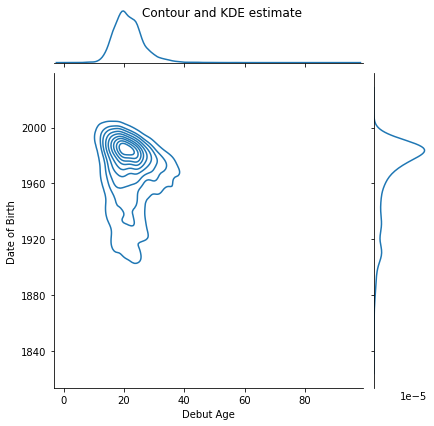

In [18]:
import seaborn as sns
#sns.kdeplot(wrestler_df['Debut Age'], wrestler_df['Date of Birth'])
h = sns.jointplot(data=wrestler_df, x='Debut Age', y='Date of Birth', kind='kde')
h.set_axis_labels('Debut Age', 'Date of Birth')
h.fig.suptitle(t='Contour and KDE estimate')

It seems that no matter what, wrestlers usually debut around their 20s. The reason there is a bigger focus on recent years is probably because it is easier to now keep track of any pro wrestlers, so for many of the older wrestlers it is likely that hte information is lost.

The reason the date of birth goes as low as the 1880s is probably just due to there being a long history of wrestling, so this isn't particularly interesting. It is interesting on the other hand that there seems to be such old debut ages, even though they don't appear in the contour directly. It is worth investigating this to see if there is anything of value there. We will look for wrestlers older than 40.

In [19]:
wrestler_df[wrestler_df['Debut Age'] > 40]

,id,Real Name,Birthplace,Date of Birth,Debut,wrestler_name,Date of Death,Height,Weight,Finisher,...,Booked Promotions,Birth Country,Region,Name Known,Debut Age,Betting Matches Won,Betting Matches Lost,Participated in Betting Match,Family Ties,rank
423,18170,Scott Stanford,"Haverstraw, New York (United States of America)",1968-08-30,2009-12-01,Scott Stanford,NaT,NaN,NaN,0,...,0.0,United States of America,USA,True,41.0,0,0,False,False,4824
1474,18888,Evander Holyfield,"Atmore, Alabama (United States of America)",1962-10-19,2007-08-13,Evander Holyfield,NaT,NaN,NaN,0,...,0.0,United States of America,USA,True,44.0,0,0,False,False,3773
1570,15466,Herschel Junior Walker,"Wrightsville, Georgia (United States of America)",1962-03-03,2010-01-30,Herschel Walker,NaT,1.85,100.0,0,...,0.0,United States of America,USA,True,47.0,0,0,False,False,3677
1767,8450,John Tunney Jr.,"Toronto, Ontario (Canada)",1935-01-01,1984-01-01,Jack Tunney,2004-01-24,NaN,NaN,0,...,0.0,Canada,USA,True,49.0,0,0,False,True,3480
3395,15028,Michael Hogewood,"Greensboro, North Carolina (United States of A...",1954-09-13,2009-02-28,Mike Hogewood,2018-09-05,NaN,NaN,0,...,0.0,United States of America,USA,True,54.0,0,0,False,False,1843
3592,16935,Billy Gram,"Cleveland, Ohio (United States of America)",1960-02-16,2007-01-01,Billy Gram,NaT,1.93,82.0,0,...,0.0,United States of America,USA,True,46.0,0,0,False,False,1646
4918,18810,Paul Reubens,NaN,1952-08-27,2010-11-01,Pee-wee Herman,NaT,NaN,NaN,0,...,0.0,NaN,Other,True,58.0,0,0,False,False,306
4927,5756,Michael David Adamle,"Euclid, Ohio (United States of America)",1949-10-04,2008-01-27,Mike Adamle,NaT,NaN,NaN,0,...,0.0,United States of America,USA,True,58.0,0,0,False,False,297
4960,16327,James Nathaniel Toney,"Grand Rapids, Michigan (United States of America)",1968-08-24,2010-08-28,James Toney,NaT,1.78,107.0,0,...,0.0,United States of America,USA,True,42.0,0,0,False,False,264
5132,3225,Linda Marie Edwards-McMahon,"New Bern, North Carolina (United States of Ame...",1948-10-04,1999-01-01,Linda McMahon,NaT,NaN,NaN,0,...,0.0,United States of America,USA,True,50.0,0,0,False,True,92


Some of these were checked manually, and it seems that most of these are just celebrities that were invited at some point to join a match as a guest wrestler. For example, Evander Holyfield was a famous boxer that joined for a match.

These won't be excluded, as it is absolutely a pathway into wrestling to just be famous or an athlete beforehand and get a boost from that (for example, Kurt Angle and The Miz fit into this description).

It would be viable to just manually add information of "had a career beforehand", but that would have to be done by hand and would take way too long to be viable.

E:\Users\Anema\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Finisher', ylabel='Trademark Moves'>

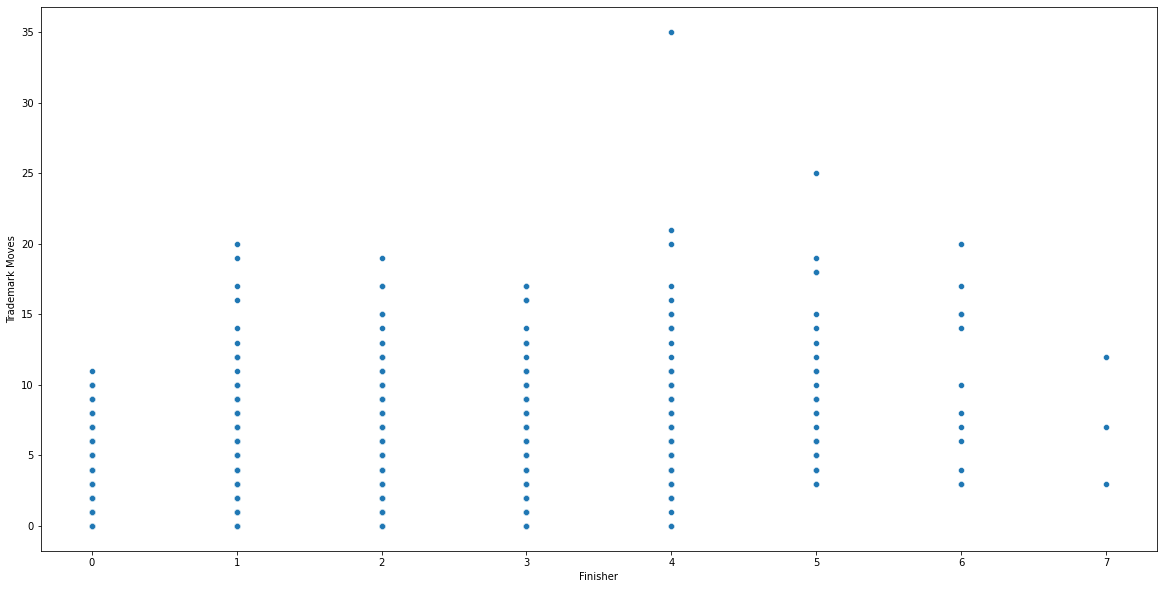

In [20]:
sns.scatterplot(wrestler_df['Finisher'], wrestler_df['Trademark Moves'])

It seems weird that it goes so high, when there are few wrestlers that seem to have so many trademark moves. Let's try and look at those wrestlers. remove

In [21]:
wrestler_df[wrestler_df['Trademark Moves'] > 20]['Finisher']

37     4
114    5
827    4
Name: Finisher, dtype: int64

Quickly checking, there seems to be nothing in particular that marks these wrestlers are outliers. They are really good, and one of them has gotten a 5 star match, but it is not enough to mark them as outliers. I will still remove them to see if I can make the plot more visual

E:\Users\Anema\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Finisher', ylabel='Trademark Moves'>

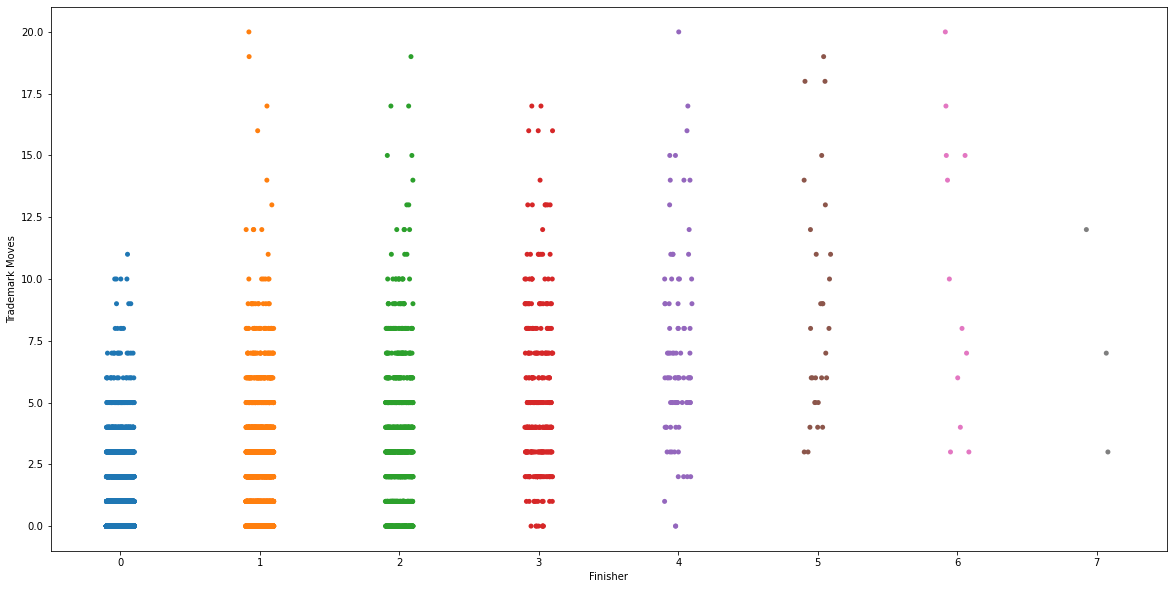

In [22]:
sns.stripplot(wrestler_df[wrestler_df['Trademark Moves'] <= 20]['Finisher'], wrestler_df[wrestler_df['Trademark Moves'] <= 20]['Trademark Moves'])

E:\Users\Anema\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Finisher', ylabel='Trademark Moves'>

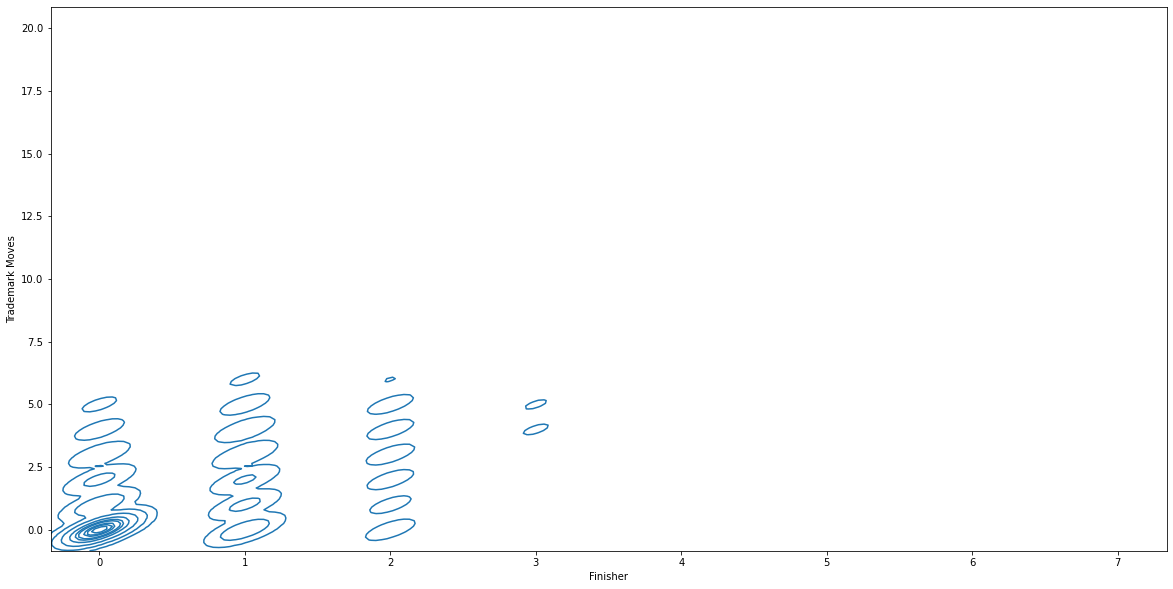

In [23]:
sns.kdeplot(wrestler_df[wrestler_df['Trademark Moves'] <= 20]['Finisher'], wrestler_df[wrestler_df['Trademark Moves'] <= 20]['Trademark Moves'])

The pyramid shape is interesting enough I

Now to do some analysis on whether a wrestler had a 5 star match or not. Woo

In [24]:
#wrestler_df['Had 5 star match'] = np.where(wrestler_df['id'].isin(merged_df['id'].unique()), True, False)

from sklearn.feature_selection import chi2, f_classif
import datetime as dt
match_wrestler_ids = merged_df['id'].unique()
y_var = np.where(wrestler_df['id'].isin(match_wrestler_ids), True, False)

# These are all variables that either require separate NLP processing (Real Name, wrestler name, birthplace)
X_var = wrestler_df.drop(['Real Name', 'Birthplace', 'wrestler_name', 'id'], axis=1)
# This is the laziest way of transforming the dates into usable numbers, which is just calculating them as seconds since the epoch
# We just overwrite the columns in the original dataset
# 1800 was picked as the year because it's the earliest available date in the dataset.
values_to_fill_nans = {'Height':0, 'Weight':0, 'Managed by': 0, 'Managed Promotions': 0, 'Booked Promotions':0, 'Debut Age': 0, 'Date of Birth': dt.datetime(1800, 1,1), 'Date of Death': dt.datetime(2100, 1,1), 'Debut': dt.datetime(1800, 1,1), 'Birth Country': ''}
X_var.fillna(values_to_fill_nans, inplace=True)

X_var['Date of Birth'] = X_var['Date of Birth'].astype(np.int64)
X_var['Date of Death'] = X_var['Date of Death'].astype(np.int64)
X_var['Debut'] = X_var['Debut'].astype(np.int64)
# For this particular analysis I'll just drop the birth country and just use the region
from sklearn.preprocessing import OneHotEncoder
X_var.drop(['Birth Country'], axis=1, inplace=True)
enc = OneHotEncoder(sparse=False)
region_encoded = enc.fit_transform(X_var[['Region']])
X_var = X_var.join(pd.DataFrame(region_encoded, columns=enc.get_feature_names_out()))
X_var.drop(['Region'], axis=1, inplace=True)
X_var.fillna(0, inplace=True)

chi_res, chi_p = chi2(X_var, y_var)

classif_res, classif_p = f_classif(X_var, y_var)

C:\Users\anema\AppData\Local\Temp/ipykernel_57044/2135833720.py:16: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  X_var['Date of Birth'] = X_var['Date of Birth'].astype(np.int64)
C:\Users\anema\AppData\Local\Temp/ipykernel_57044/2135833720.py:17: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  X_var['Date of Death'] = X_var['Date of Death'].astype(np.int64)
C:\Users\anema\AppData\Local\Temp/ipykernel_57044/2135833720.py:18: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  X_var['Debut'] = X_var['Debut'].astype(np.int64)


AttributeError: 'OneHotEncoder' object has no attribute 'get_feature_names_out'

In [ ]:
chi_df = pd.DataFrame([chi_res, chi_p], columns=X_var.columns, index=['Chi res', 'P-Values']).transpose()
chi_df.sort_values(by='Chi res', inplace=True, ascending=False)

classif_df = pd.DataFrame([classif_res, classif_p], columns=X_var.columns, index=['F Score', 'P-Values']).transpose()
classif_df.sort_values(by='F Score', inplace=True, ascending=False)

In [ ]:
fig, axes = plt.subplots(ncols=2)

classif_df.iloc[:10, :]['F Score'].plot(kind='bar', ax=axes[0], title='Top 10 F-Scores')
chi_df.iloc[:10, :]['Chi res'].plot(kind='bar', ax=axes[1], title='Top 10 Chi squared scores')

4-14 best Based on this, it seems that a couple of common traits show up as the most desirable. It is not particularly suprising that rank is such a good determiner, for them to appear in the rank list they seem to both require a certain number of reviews, so they would already be popular. And it makes sense that a popular wrestler is one that has very good matches.

## Additional Plots

In [51]:
all_wrestlers = wrestler_df # 30k wrestlers
ranked_wrestlers = wrestler_df[wrestler_df['rank'] > 0] # 5k ranked wrestlers
fivestar_wrestlers = merged_df; # 5-star-match wrestlers (554 wrestlers)
all_wrestlers.columns

Index(['id', 'Real Name', 'Birthplace', 'Date of Birth', 'Debut',
       'wrestler_name', 'Date of Death', 'Height', 'Weight', 'Finisher',
       'Interesting Weblinks', 'Management', 'Nickname', 'Stables',
       'Tag Teams', 'Tournament Wins', 'Trademark Moves', 'Trainer',
       'Managed by', 'Shows Commentated', 'Students', 'Booked Promotion',
       'Managed Promotions', 'Nicknames', 'Managed Promotion', 'Student',
       'Booked Promotions', 'Birth Country', 'Region', 'Name Known',
       'Debut Age', 'Betting Matches Won', 'Betting Matches Lost',
       'Participated in Betting Match', 'Family Ties', 'rank'],
      dtype='object')

In [120]:
all_wrestlers['Birthplace'].dropna().sort_values().drop_duplicates()

24617                A Coruña, Galicia (Spain)
23143    Aachen, Nordrhein-Westfalen (Germany)
8472            Aalborg, Nordjylland (Denmark)
2978                Abashiri, Hokkaido (Japan)
13234    Abbotsford, British Columbia (Canada)
                         ...                  
16316                         umen (Bulgaria)
16760                           Árgos (Greece)
9390              Århus, Midtjylland (Denmark)
8291                   Érmihályfalva (Hungary)
9096              Évry, Île-de-France (France)
Name: Birthplace, Length: 4589, dtype: object

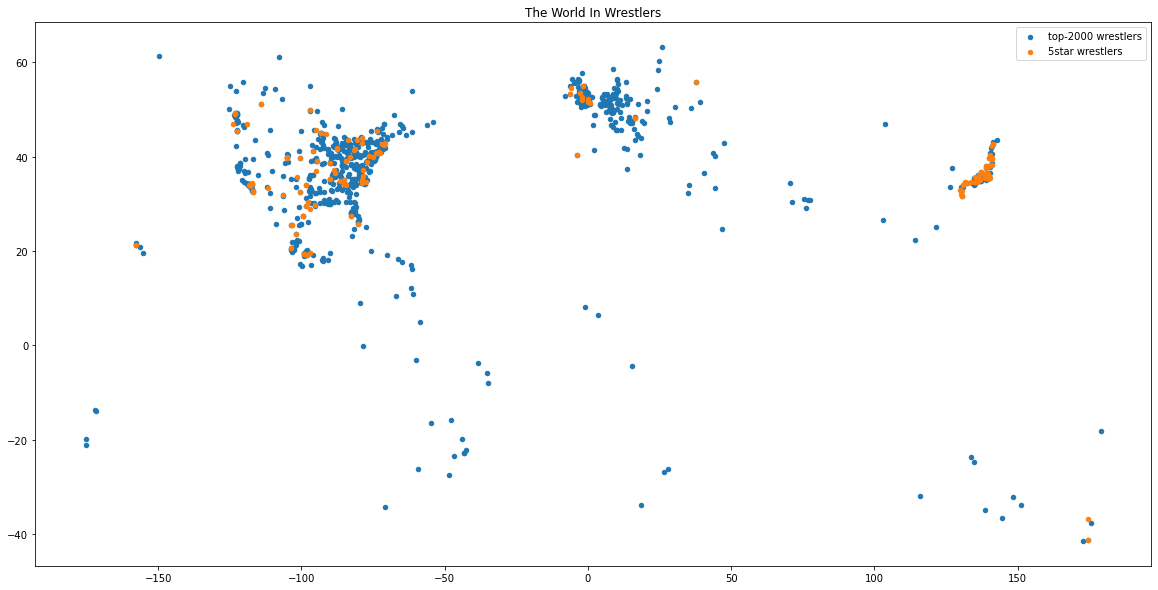

In [313]:
wrestlers_2000 = ranked_wrestlers[ranked_wrestlers['rank'] <= 2000][['id', 'Birthplace']].dropna()
b_2000_i = wrestlers_2000.drop_duplicates('Birthplace').index
birthplaces_2000 = pd.read_csv('Data\misc\wrestler_birthplaces_top2000.csv')
birthplaces_2000.index = b_2000_i

wrestlers_5star = fivestar_wrestlers[['id', 'Birthplace']].dropna()
b_5star_i = wrestlers_5star.drop_duplicates('Birthplace').index
birthplaces_5star = pd.read_csv('Data\misc\wrestler_birthplaces_5star.csv')
birthplaces_5star.index = b_5star_i
plt.scatter(birthplaces_2000.lon, birthplaces_2000.lat, s=20, label='top-2000 wrestlers')
plt.scatter(birthplaces_5star.lon, birthplaces_5star.lat, s=20, label='5star wrestlers')
plt.title('The World In Wrestlers');
plt.legend()
plt.savefig('Wrestler World Map');

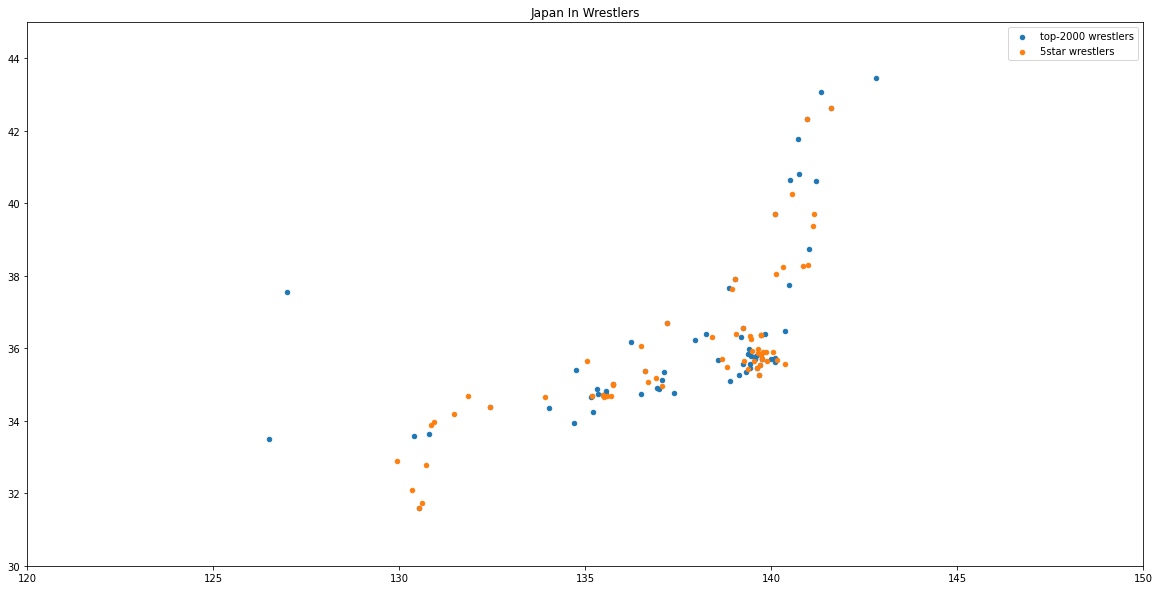

In [318]:
plt.scatter(birthplaces_2000.lon, birthplaces_2000.lat, s=20, label='top-2000 wrestlers')
plt.scatter(birthplaces_5star.lon, birthplaces_5star.lat, s=20, label='5star wrestlers')
plt.title('Japan In Wrestlers');
plt.legend()
plt.xlim((120, 150))
plt.ylim((30, 45))
plt.savefig('Wrestler Japan Map');

## Predicting the rank info
We want to see if there are any interesting correlations between the wrestler's rank and the other information.

In [ ]:
# These are all variables that either require separate NLP processing (Real Name, wrestler name, birthplace)
y_var = wrestler_df['rank']
X_var = wrestler_df.drop(['Real Name', 'Birthplace', 'wrestler_name', 'rank', 'id'], axis=1)
# This is the laziest way of transforming the dates into usable numbers, which is just calculating them as seconds since the epoch
# We just overwrite the columns in the original dataset
# 1837 was picked as the year because it's the earliest available date in the dataset.
values_to_fill_nans = {'Height':0, 'Weight':0, 'Managed by': 0, 'Managed Promotions': 0, 'Booked Promotions':0, 'Debut Age': 0, 'Date of Birth': dt.datetime(1800, 1,1), 'Date of Death': dt.datetime(2100, 1,1), 'Debut': dt.datetime(1800, 1,1), 'Birth Country': ''}
X_var.fillna(values_to_fill_nans, inplace=True)

X_var['Date of Birth'] = X_var['Date of Birth'].astype(np.int64)
X_var['Date of Death'] = X_var['Date of Death'].astype(np.int64)
X_var['Debut'] = X_var['Debut'].astype(np.int64)
# For this particular analysis I'll just drop the birth country and just use the region
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import f_regression, mutual_info_regression
X_var.drop(['Birth Country'], axis=1, inplace=True)
enc = OneHotEncoder(sparse=False)
region_encoded = enc.fit_transform(X_var[['Region']])
X_var = X_var.join(pd.DataFrame(region_encoded, columns=enc.get_feature_names_out()))
X_var.drop(['Region'], axis=1, inplace=True)

mi = mutual_info_regression(X_var, y_var)

f_res, f_p = f_regression(X_var, y_var)

In [ ]:
mi_df = pd.Series(mi, index=X_var.columns)
mi_df.sort_values(inplace=True, ascending=False)
mi_df.iloc[:10].plot(kind='bar')

In [ ]:
f_df = pd.DataFrame([f_res, f_p], columns=X_var.columns, index=['F Score', 'P-Values']).transpose()
f_df.sort_values(by='P-Values', inplace=True)

f_df.iloc[:10, :]['F Score'].plot(kind='bar')

In [ ]:
y_var = wrestler_df['rank']
X_var = wrestler_df.drop(['Real Name', 'Birthplace', 'wrestler_name', 'rank', 'id'], axis=1)
# This is the laziest way of transforming the dates into usable numbers, which is just calculating them as seconds since the epoch
# We just overwrite the columns in the original dataset
# 1837 was picked as the year because it's the earliest available date in the dataset.
values_to_fill_nans = {'Height':0, 'Weight':0, 'Managed by': 0, 'Managed Promotions': 0, 'Booked Promotions':0, 'Debut Age': 0, 'Date of Birth': dt.datetime(1800, 1,1), 'Date of Death': dt.datetime(2100, 1,1), 'Debut': dt.datetime(1800, 1,1), 'Birth Country': ''}
X_var.fillna(values_to_fill_nans, inplace=True)

X_var['Date of Birth'] = X_var['Date of Birth'].astype(np.int64)
X_var['Date of Death'] = X_var['Date of Death'].astype(np.int64)
X_var['Debut'] = X_var['Debut'].astype(np.int64)

In [ ]:
from interpret.glassbox import ExplainableBoostingRegressor
from interpret import show
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_var, y_var)

seed = 1

ebr = ExplainableBoostingRegressor(random_state=seed)
ebr.fit(X_train, y_train)

In [ ]:
ebr_global = ebr.explain_global()
show(ebr_global)

In [ ]:
y_pred = ebr.predict(X_test)

from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
print(explained_variance_score(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

It is not the best predictor. Considering the amount of entries without any rank, this does make some sense.

## Likelihood of getting a 5 star match
We'll use the explainable boosting machine to get more information about the wrestlers that have had 5 star matches, and see if there is anything in their history that can provide additional information.

So we'll be working on having a classifier that predicts the likelihood of having a 5 star match. We'll drop any names, and we won't work on NLP stuff for now.

In [ ]:
# The first thing to do is to add a column that says whether a wrestler has had a 5 star match or not.
# We will run the boosted glass box classification model that was explained on it. To try and see if there is anything of value that we can learn.

# Dropping the column so that we can train on it separately
#wrestler_df.drop(['Had 5 star match'], axis=1, inplace=True)

# I looked into how ebm handles categorical variables, for strings it pretty much just does label encoding
# I will still remove names, as they should have some NLP done to properly process them. This was deemed as too much effort
# But countries will remain
match_wrestler_ids = merged_df['id'].unique()
y_var = np.where(wrestler_df['id'].isin(match_wrestler_ids), True, False)

X_var = wrestler_df.drop(['id', 'Real Name', 'Birthplace', 'wrestler_name'], axis=1)

In [ ]:
# We have to deal with missing values, for now I'll take a very simple approach to most of them and hope it's enough
values_to_fill_nans = {'Height':0, 'Weight':0, 'Managed by': 0, 'Managed Promotions': 0, 'Booked Promotions':0, 'Debut Age': 0, 'Date of Birth': dt.datetime(1800, 1,1), 'Date of Death': dt.datetime(2100, 1,1), 'Debut': dt.datetime(1800, 1,1), 'Birth Country': ''}
X_var.fillna(values_to_fill_nans, inplace=True)

X_var['Date of Birth'] = X_var['Date of Birth'].astype(np.int64)
X_var['Date of Death'] = X_var['Date of Death'].astype(np.int64)
X_var['Debut'] = X_var['Debut'].astype(np.int64)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_var, y_var, stratify=y_var)

from interpret import show
from interpret.glassbox import ExplainableBoostingClassifier

seed = 1
ebm = ExplainableBoostingClassifier(random_state=seed)
ebm.fit(X_train, y_train)

In [ ]:
plt.rcParams['figure.figsize'] = [10,5]
ebm_global = ebm.explain_global()
show(ebm_global)

In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report
y_pred = ebm.predict(X_test)
print("Always false accuracy: " + str((len(y_test) - y_test.sum())/len(y_test)))
print(accuracy_score(y_test, y_pred))
print(balanced_accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
# He has optimal stats (according to the trained classifier)
super_jerry = pd.Series({'Date of Birth': (dt.datetime(1983,12,27)).astype(np.int64), 'Debut': (dt.datetime.today()).astype(np.int64), 'Date of Death': (dt.datetime(2100, 1,1)).astype(np.int64), 'Height': 1.84, 'Weight': 84.0, 'Finisher': 5, 'Interesting Weblinks': 4, 'Management': 0, 'Nickname': 0, 'Stables': 10, 'Tag Teams': 6, 'Tournament Wins': 8, 'Trademark Moves': 15, 'Trainer': 1, 'Managed by': 1, 'Shows Commentated': 1, 'Students': 1, 'Booked Promotion': 1, 'Managed Promotions': 1, 'Nicknames': 1, 'Managed Promotion': 1, 'Student': 1, 'Booked Promotions': 1, 'Birth Country': 'Greece', 'Region': 'Other', 'Name Known': 1, 'Debut Age': 38, 'Betting Matches Won': 6, 'Betting Matches Lost': 0, 'Participated in Betting Match': 1, 'Family Ties': 1, 'rank': 5247})

In [ ]:
ebm.predict_proba(pd.DataFrame([super_jerry]))

I am not sure if this counts as overpredicting for the false values or not. The other metrics for True do make it seem like that, but the classifier does have a lower accuracy than if it just predicted false all the time. So it does seem to be at least trying, even if it is not perfect.

You can see that when you look at the precision, recall and f1-score for True, it is much much lower. Which does make sense, it is a heavily imbalanced dataset and we used very default parameters. It did try to predict some of the True values with middling results, so it does seem like it learned something.

The more interesting thing to note is that this classifier gives Jerry a very high chance of getting a five star match! This is a super inflated Jerry, but it does mean that it is possible, he just has to make his dreams a reality!

## Difference between rank and classifier

It also seems that a predictor for rank is much than a predictor for 5 star matches. Even though rank is a somewhat important value.

How can we explain this disconnect between the two columns? The first likely candidate is due to the way we're dealing with unranked wrestlers. As of now, we just mark them all as having a score of 0. This means it's likely the system is learning to just mark things as 0, just because it has learned that it is the most common score.

To test this hypothesis, we will try two options:
- Regression only on ranked wrestlers
- Classification on ranked vs unranked wrestlers

We will also do some on analysis on the number of NaNs per row comparing the ranked vs the unranked wrestlers (as the number of wrestlers with 5 star matches is a relatively small amount).

Last thing to do is create a separate classifier model that will drop even more columns, focusing on those filled with NaNs. We will have to manually check them to be sure which ones should be dropped though.


In [ ]:
# First thing to run is a regression only on the ranked wrestlers
y_var = wrestler_df[wrestler_df['rank'] > 0]['rank']
X_var = wrestler_df[wrestler_df['rank'] > 0].drop(['Real Name', 'Birthplace', 'wrestler_name', 'rank', 'id'], axis=1)
# This is the laziest way of transforming the dates into usable numbers, which is just calculating them as seconds since the epoch
# We just overwrite the columns in the original dataset
values_to_fill_nans = {'Height':0, 'Weight':0, 'Managed by': 0, 'Managed Promotions': 0, 'Booked Promotions':0, 'Debut Age': 0, 'Date of Birth': dt.datetime(1800, 1,1), 'Date of Death': dt.datetime(2100, 1,1), 'Debut': dt.datetime(1800, 1,1), 'Birth Country': ''}
X_var.fillna(values_to_fill_nans, inplace=True)

X_var['Date of Birth'] = X_var['Date of Birth'].astype(np.int64)
X_var['Date of Death'] = X_var['Date of Death'].astype(np.int64)
X_var['Debut'] = X_var['Debut'].astype(np.int64)

from interpret.glassbox import ExplainableBoostingRegressor
from interpret import show
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_var, y_var)

seed = 1

ebr = ExplainableBoostingRegressor(random_state=seed)
ebr.fit(X_train, y_train)

In [ ]:
y_pred = ebr.predict(X_test)

from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
print(explained_variance_score(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

ebr_global = ebr.explain_global()
show(ebr_global)

Now we'll run a classification on whether a wrestler is ranked or not

In [ ]:
y_var = wrestler_df['rank'] > 0

X_var = wrestler_df.drop(['id', 'Real Name', 'Birthplace', 'wrestler_name', 'rank'], axis=1)

# We have to deal with missing values, for now I'll take a very simple approach to most of them and hope it's enough
values_to_fill_nans = {'Height':0, 'Weight':0, 'Managed by': 0, 'Managed Promotions': 0, 'Booked Promotions':0, 'Debut Age': 0, 'Date of Birth': dt.datetime(1800, 1,1), 'Date of Death': dt.datetime(2100, 1,1), 'Debut': dt.datetime(1800, 1,1), 'Birth Country': ''}
X_var.fillna(values_to_fill_nans, inplace=True)

X_var['Date of Birth'] = X_var['Date of Birth'].astype(np.int64)
X_var['Date of Death'] = X_var['Date of Death'].astype(np.int64)
X_var['Debut'] = X_var['Debut'].astype(np.int64)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_var, y_var, stratify=y_var)

from interpret.glassbox import ExplainableBoostingClassifier

seed = 1
ebm = ExplainableBoostingClassifier(random_state=seed)
ebm.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report
y_pred = ebm.predict(X_test)
print("Always false accuracy: " + str((len(y_test) - y_test.sum())/len(y_test)))
print(accuracy_score(y_test, y_pred))
print(balanced_accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
plt.rcParams['figure.figsize'] = [10,5]
ebm_global = ebm.explain_global()
show(ebm_global)

# Match analysis
While the match analysis is more restricted (our focus was on scraping the wrestlers, not the event info), there can still be some interesting analysis to be done.

Another thing that is added to the matches is the 'gender' of the promotion. Japanese promotions tend to only focus on one gender of wrestling, and for the other regions a quick check was done to see where their wrestlers came from.

Some of these features would be interesting for the whole set of wrestlers, but they would be near impossible to add to the wrestler list itself without additional scraping.

Also, WWE and WWF are essentially the same company, but had to go through a name change due to legal problems with the World Wide Fund. There are other cases where a company is 'descended' from a different one, or where they've bought each other, but we will keep the original promotions to try and represent the 'spirit' of the original booking.

In [ ]:
# To the match info, I'll add whether the wrestler was in their home "region"
# TODO: Add this to the match info
merged_df['Home wrestler'] = merged_df['Region'] == merged_df['Promotion Country']

# TODO: Add the gender info of the promotion
# It's easier to list the female promotions, and then just to an np where
female_promotions = ['AJW', 'JWP', 'Stardom']

merged_df['Female promotion'] = np.where(merged_df['Promotion'].isin(female_promotions), True, False)



In [ ]:
# First I'll start by plotting the relation between it being a local wrestler or a foreign one
# I'll use the counts for each of the four regions that are used
temp = merged_df.groupby(['Promotion Country', 'Home wrestler'])

# I just input the values manually, because thinking of how to code such a small df was suffering
local_temp = pd.DataFrame({'True': [314, 8, 2, 4, 123], 'False': [59, 4, 2, 0, 38]}, index=['Japan', 'Mexico', 'Other', 'UK', 'USA'])

local_temp.plot(kind='bar', stacked=True, ylabel='Count of locals')
plt.legend(['Local', 'Foreign'])

In [ ]:
# The previous plot wasn't good for getting percentages,
local_temp.divide(local_temp.sum(axis=1), axis=0).plot(kind='bar', stacked=True, ylabel='Percent of locals')
plt.legend(['Local', 'Foreign'])

In [ ]:
match_wrestler_info.groupby(['Promotion']).size().sort_values()

In [ ]:
year_matches = pd.to_datetime(match_wrestler_info['Date']).dt.year.value_counts()
year_matches.sort_index().plot()

The last plot is actually super interesting, as the eras where the best matches were had don't line up with the two biggest wrestling booms (golden age and attitude era). This might be because these periods of popularity were held in the US. Which (considering the market size of their promotions), tends to have relatively few matches.

An interesting plot would be worldwide income of wrestling vs the number of matches, but for most companies this is private. On top of that, just parsing the information would be really hard when you take into account the number of companies, even if you were to restricted only to "important" companies.

In [ ]:
temp_year_match = match_wrestler_info.copy()
temp_year_match = temp_year_match.iloc[:, :-12]
temp_year_match['Year'] = pd.to_datetime(match_wrestler_info['Date']).dt.year

temp = temp_year_match.groupby(['Year', 'Promotion Country']).size().reset_index()

res = pd.DataFrame(0, index=temp['Year'].unique(), columns=temp['Promotion Country'].unique())
for index, row in temp.iterrows():
    res.loc[row['Year']][row['Promotion Country']] = row[0]

res.plot(kind='bar', stacked=True, ylabel='Counts')

In [ ]:
temp_year_match = match_wrestler_info.copy()
temp_year_match = temp_year_match.iloc[:, :-12]
temp_year_match['Year'] = pd.to_datetime(match_wrestler_info['Date']).dt.year

temp = temp_year_match.groupby(['Year', 'Promotion Country']).size().reset_index()

res = pd.DataFrame(0, index=temp['Year'].unique(), columns=temp['Promotion Country'].unique())
for index, row in temp.iterrows():
    res.loc[row['Year']][row['Promotion Country']] = row[0]

res.plot(kind='bar', stacked=True, ylabel='Counts')

In [ ]:
local_wrestlers_per_year = merged_df[~merged_df['Home wrestler']].copy()
local_wrestlers_per_year['Year'] = pd.to_datetime(local_wrestlers_per_year['Date']).dt.year

temp = local_wrestlers_per_year.groupby(['Year', 'Promotion Country']).size().reset_index()

res = pd.DataFrame(0, index=temp['Year'].unique(), columns=temp['Promotion Country'].unique())
for index, row in temp.iterrows():
    res.loc[row['Year']][row['Promotion Country']] = row[0]

res.plot(kind='bar', stacked=True, ylabel='Counts')